In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [2]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [3]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [4]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)   # ✅ FIXED
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

In [5]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('./weights/Meso4_DF')

In [6]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 5690 images belonging to 2 classes.


In [7]:
# Checking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

In [8]:
# '.ipynb_checkpoints' is a *hidden* file Jupyter creates for autosaves
# It must be removed for flow_from_directory to work.
!rmdir /s /q c:data\.ipynb_checkpoints

# Equivalent command in Unix (for Mac / Linux users)
# !rm -r /Users/mikhaillenko/mesonet/mesonet/data/.ipynb_checkpoints/

The system cannot find the file specified.


In [9]:
# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

# Re-checking class assignment after removing it
generator.class_indices

Found 5690 images belonging to 2 classes.


{'DeepFake': 0, 'Real': 1}

1/1 [==============================] - 0s 456ms/step
Predicted likelihood: 0.6685
Actual label: 1
1/1 [==============================] - 0s 29ms/step

Correct prediction: True


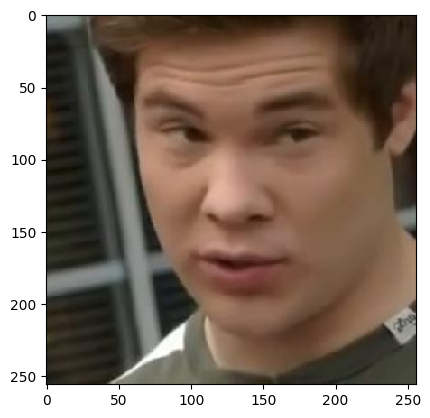

In [10]:
# Rendering image X with label y for MesoNet
X, y = next(generator)

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [11]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

Total images: 5690
5690/5690 [==============================] - 112s 20ms/step

Optimal Threshold: 0.718, ROC AUC: 0.507

Validation Accuracy: 0.508

Confusion Matrix:
[[1907  938]
 [1860  985]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.67      0.58      2845
           1       0.51      0.35      0.41      2845

    accuracy                           0.51      5690
   macro avg       0.51      0.51      0.50      5690
weighted avg       0.51      0.51      0.50      5690



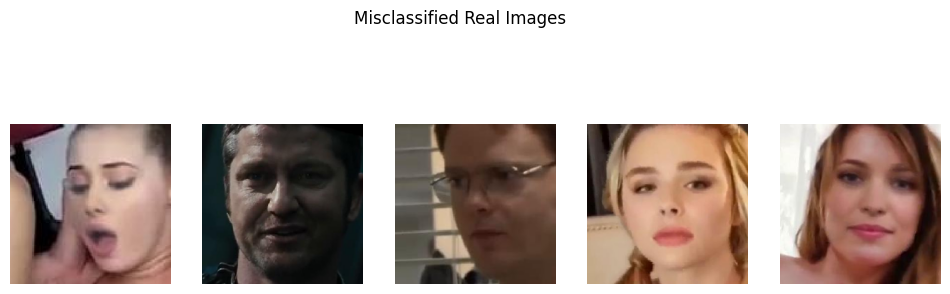

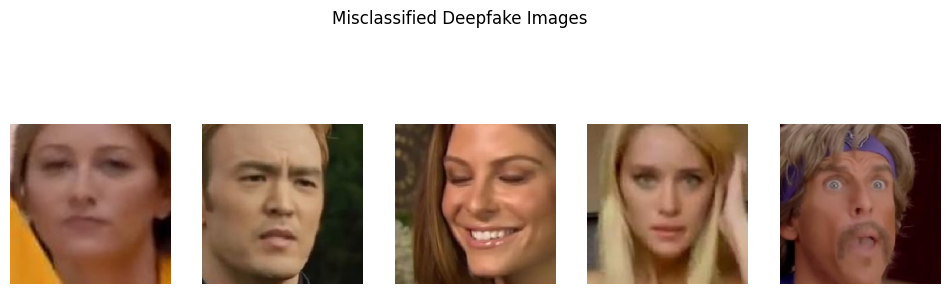

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Reset generator
generator.reset()
print("Total images:", len(generator.labels))

# 1️⃣ Get predictions
pred_probs = meso.model.predict(generator, verbose=1)  # shape (N,1)
all_labels = np.array(generator.labels)

# 2️⃣ Find optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, pred_probs)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold: {optimal_threshold:.3f}, ROC AUC: {roc_auc:.3f}")

# 3️⃣ Apply threshold
all_preds = (pred_probs >= optimal_threshold).astype(int).flatten()

# 4️⃣ Categorize predictions
correct_real, correct_deepfake = [], []
misclassified_real, misclassified_deepfake = [], []

for i in range(len(all_labels)):
    true_label = all_labels[i]
    pred_label = all_preds[i]
    
    if true_label == 1:  # Real
        if pred_label == 1:
            correct_real.append(i)
        else:
            misclassified_real.append(i)
    else:  # Deepfake
        if pred_label == 0:
            correct_deepfake.append(i)
        else:
            misclassified_deepfake.append(i)

# 5️⃣ Summary
accuracy = np.mean(all_preds == all_labels)
print(f"\nValidation Accuracy: {accuracy:.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 6️⃣ Function to visualize misclassified images
def show_images(indices, generator, title, n_images=5):
    plt.figure(figsize=(12,4))
    for i, idx in enumerate(indices[:n_images]):
        img, _ = generator[idx]  # generator returns (batch, labels)
        plt.subplot(1, n_images, i+1)
        plt.imshow(img[0])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 7️⃣ Visualize misclassified examples
if misclassified_real:
    show_images(misclassified_real, generator, "Misclassified Real Images")
if misclassified_deepfake:
    show_images(misclassified_deepfake, generator, "Misclassified Deepfake Images")

In [ ]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

TypeError: Invalid shape () for image data

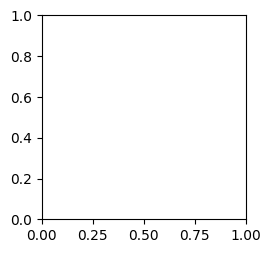

In [18]:
plotter(correct_real, correct_real_pred)

In [ ]:
plotter(misclassified_real, misclassified_real_pred)

In [ ]:
plotter(correct_deepfake, correct_deepfake_pred)

In [ ]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)

In [16]:
print("Mean prediction probability:", np.mean(pred_probs))

Mean prediction probability: 0.5364899


In [19]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(all_labels, pred_probs)
print("AUC Score:", auc)

AUC Score: 0.49675658411361695


In [20]:
print(generator.class_indices)

{'DeepFake': 0, 'Real': 1}


In [21]:
print("Class indices:", generator.class_indices)
print("First 10 labels:", generator.labels[:10])
print("First 10 predictions:", pred_probs[:10])

Class indices: {'DeepFake': 0, 'Real': 1}
First 10 labels: [0 0 0 0 0 0 0 0 0 0]
First 10 predictions: [[0.9847509 ]
 [0.8978644 ]
 [0.781959  ]
 [0.53388125]
 [0.8866551 ]
 [0.21126153]
 [0.67682135]
 [0.99412525]
 [0.72731507]
 [0.9994252 ]]


In [22]:
print(np.unique(all_labels, return_counts=True))

(array([0, 1]), array([2845, 4259], dtype=int64))


In [23]:
import os
import random

def balance_folder(folder_path, target_count):
    files = os.listdir(folder_path)
    random.shuffle(files)

    for file in files[target_count:]:
        os.remove(os.path.join(folder_path, file))

# Minority count = 2845
balance_folder(r"C:\Users\sarat\AI_Projects\python-youtube-code\Deepfake-detection\data\Real", 2845)

In [13]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

NameError: name 'model' is not defined

In [14]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(generator.labels),
    y=generator.labels
)

class_weights = dict(enumerate(class_weights))

model.fit(
    generator,
    epochs=10,
    class_weight=class_weights
)

NameError: name 'model' is not defined